In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## Importing Packages

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.engine.sequential import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import metrics
from keras.optimizers import Adam

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
os.chdir("./..")
REPO_PATH = os.getcwd().replace("\\" , "/")
DATA_PATH = f"{REPO_PATH}/data"
TRAIN_DATA_PATH, VAL_DATA_PATH, TEST_DATA_PATH = f"{DATA_PATH}/train", f"{DATA_PATH}/val", f"{DATA_PATH}/test"
MODEL_CHECKPOINTS_PATH = f"{REPO_PATH}/model_checkpoints"
LABELS = {0: "Carrying", 1: "Normal", 2: "Threat"}

## Reading in Dataset to Flow

In [5]:
batch_size = 32
image_length = 224
image_size = (image_length, image_length)

train_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.3)

train_batches = train_datagen.flow_from_directory(
    TRAIN_DATA_PATH,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = "categorical",
    color_mode = "grayscale",
    shuffle = True,
    seed = 4243,
)

validation_batches = train_datagen.flow_from_directory(
    VAL_DATA_PATH,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = "categorical",
    color_mode = "grayscale",
    shuffle = True,
    seed = 4243,
)

Found 4320 images belonging to 3 classes.
Found 540 images belonging to 3 classes.


In [6]:
# For Visualization of images and labels
def plot_images(image_array):
    num_images_per_row = 5
    num_images = len(image_array)
    num_rows = num_images // num_images_per_row
    if num_rows * 5 < num_images: num_rows += 1
    fig, axes = plt.subplots(num_rows, num_images_per_row)
    axes = axes.flatten()
    for img, ax in zip(image_array, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def print_label(labels):
    if labels.shape == (3,):
        print(LABELS[np.where(labels == 1)[0][0]])
        return
    for label in labels:
        print(LABELS[np.where(label == 1)[0][0]])


## Building Model

In [7]:
# Create a VGG 16 model
def create_model():
    model = Sequential()

    model.add(Conv2D(input_shape=(image_length,image_length,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dense(units=3, activation="softmax")) 

    return model

In [8]:
# Cell to start training
model = create_model()

model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001),
              metrics = ['accuracy', metrics.categorical_accuracy])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

## Training Model

In [9]:
max_epochs = 10
patience = 5

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=patience),
    tf.keras.callbacks.ModelCheckpoint(filepath=f'{MODEL_CHECKPOINTS_PATH}/vgg16_grayscale_aug.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

history = model.fit(
        train_batches,
        steps_per_epoch = train_batches.__len__(),
        epochs = max_epochs,
        validation_data = validation_batches,
        validation_steps = validation_batches.__len__())

Epoch 1/10
135/135 [==============================] - 123s 833ms/step - loss: 1.0989 - accuracy: 0.3275 - categorical_accuracy: 0.3275 - val_loss: 1.0986 - val_accuracy: 0.3333 - val_categorical_accuracy: 0.3333
Epoch 2/10
135/135 [==============================] - 110s 811ms/step - loss: 1.0988 - accuracy: 0.3197 - categorical_accuracy: 0.3197 - val_loss: 1.0986 - val_accuracy: 0.3333 - val_categorical_accuracy: 0.3333
Epoch 3/10
135/135 [==============================] - 110s 812ms/step - loss: 1.0987 - accuracy: 0.3213 - categorical_accuracy: 0.3213 - val_loss: 1.0986 - val_accuracy: 0.3333 - val_categorical_accuracy: 0.3333
Epoch 4/10
135/135 [==============================] - 110s 810ms/step - loss: 1.0987 - accuracy: 0.3199 - categorical_accuracy: 0.3199 - val_loss: 1.0986 - val_accuracy: 0.3333 - val_categorical_accuracy: 0.3333
Epoch 5/10
135/135 [==============================] - 112s 830ms/step - loss: 1.0987 - accuracy: 0.3266 - categorical_accuracy: 0.3266 - val_loss: 1.098

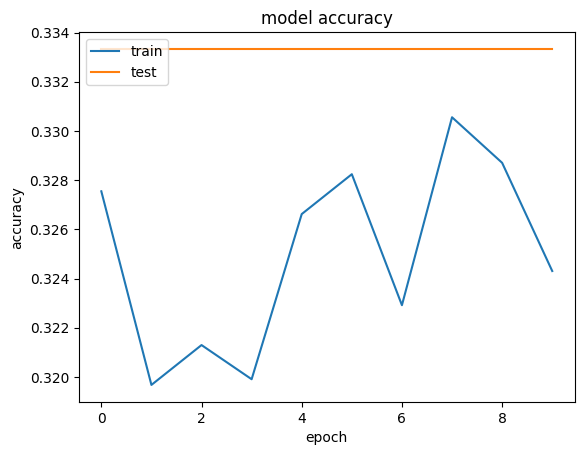

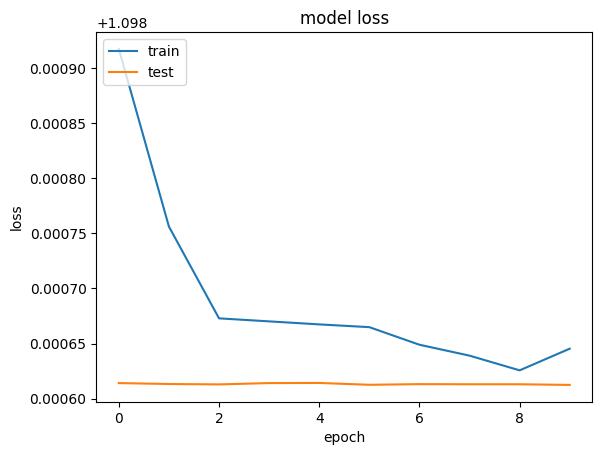

In [10]:
# summarize history for accuracy
history = history.history
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

From the training accuracy above, we see that training accuracy converges after 2 epochs. Thus, we can infer that the low accuracy has nothing to do with the number of epochs (as we have already reached convergence). It could be due to:
1) Low model complexity (VGG16 is a shallow model with only 2 layers)
2) Small image size (resizing to 128x128 removes important information)

It is likely not due to lack of image augmentation techniques, which are only added to allow the model to better generalize to testing images.